# Analysis of 3k T cells from cancer

In this tutorial, we re-analize single-cell TCR/RNA-seq data from <cite data-cite="Wu2020">Wu2020</cite> generated on the 10x VDJ platform. The original dataset consists of >140k T cells from 14 treatment-naive patients across four different types of cancer.

For this tutorial, to speed up computations, we use a downsampled version of 3k cells.

<div class="alert alert-warning">

**Warning:** This tutorial is under construction!

</div>

In [1]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("../..")
import sctcrpy as st
import pandas as pd
import numpy as np
import scanpy as sc
from matplotlib import pyplot as plt

The Dataset ships with the `sctcrpy` package:

In [2]:
adata = st.datasets.wu2020_3k()

`adata` is a regular `scanpy` AnnData object:

In [3]:
adata.shape

(3000, 30727)

It just has additional TCR-related columns in `obs`:

In [4]:
adata.obs

,TRA_1_c_gene,TRA_1_cdr3,TRA_1_cdr3_len,TRA_1_cdr3_nt,TRA_1_d_gene,TRA_1_expr,TRA_1_j_gene,TRA_1_junction_ins,TRA_1_v_gene,TRA_2_c_gene,...,TRB_2_junction_ins,TRB_2_v_gene,batch,clonotype_orig,has_tcr,ident,multi_chain,patient,sample,source
LN3_ACTGATGGTGCAGACA-2-11,TRAC,CATRGYSSASKIIF,14.0,TGTGCTACGAGGGGGTACAGCAGTGCTTCCAAGATAATCTTT,None,1.0,TRAJ3,None,TRAV17,None,...,None,None,11,lung3.tn.C3374,True,11,False,Lung3,LN3,NAT
EN1_CTTAGGAGTACTCGCG-1-5,None,None,NaN,None,None,NaN,None,None,None,None,...,None,None,5,endo1.tn.C4902,True,0,False,Endo1,EN1,NAT
LN5_TACCTTAGTAGGAGTC-1-7,TRAC,CVVSDSRSGYALNF,14.0,TGTGTTGTGAGTGATTCGCGGTCCGGGTATGCACTCAACTTC,None,2.0,TRAJ41,None,TRAV8-2,None,...,None,None,7,lung5.tn.C722,True,6,False,Lung5,LN5,NAT
ET1_TTTGTCAGTAAGGATT-2-16,None,None,NaN,None,None,NaN,None,None,None,None,...,None,None,16,endo1.tn.C4284,True,12,False,Endo1,ET1,Tumor
LT1_ACGGCCATCCGAGCCA-2-24,TRAC,CTVNYGGSQGNLIF,14.0,TGCACCGTGAATTATGGAGGAAGCCAAGGAAATCTCATCTTT,None,6.0,TRAJ42,None,TRAV26-2,None,...,None,None,24,lung1.tn.C476,True,18,False,Lung1,LT1,Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LT1_GCCTCTACATCTACGA-2-24,TRAC,CAYRSQSGTYKYIF,14.0,TGTGCTTATAGGAGCCAATCAGGAACCTACAAATACATCTTT,None,16.0,TRAJ40,None,TRAV38-2DV8,TRAC,...,None,None,24,lung1.tn.C2245,True,8,False,Lung1,LT1,Tumor
LT2_TTAGTTCGTTTAGCTG-1-30,TRAC,CAVGNFNKFYF,11.0,TGTGCTGTGGGGAACTTCAACAAATTTTACTTT,None,6.0,TRAJ21,None,TRAV2,None,...,None,None,30,lung2.tn.C4037,True,6,False,Lung2,LT2,Tumor
ET2_TGCGGGTGTGACCAAG-1-22,TRAC,CLVGEGEGRRALTF,14.0,TGCCTCGTGGGTGAAGGGGAGGGCAGGAGAGCACTTACTTTT,None,2.0,TRAJ5,None,TRAV4,None,...,None,None,22,endo2.tn.C6,True,7,False,Endo2,ET2,Tumor
CT1_TTCTCAATCCAAGTAC-1-13,TRAC,CAVKDSNYQLIW,12.0,TGTGCTGTGAAGGATAGCAACTATCAGTTAATCTGG,None,3.0,TRAJ33,None,TRAV1-2,None,...,None,None,13,colon1.tn.C200,True,12,False,Colon1,CT1,Tumor


## Preprocess Transcriptomics data

Transcriptomics data needs to be filtered and preprocessed as with any other single-cell dataset.
Here, we quickly preprocess transcriptomics data, roughly following the [scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

In [5]:
sc.pp.filter_cells(adata, min_genes=700)
sc.pp.filter_cells(adata, min_counts=2000)
sc.pp.filter_genes(adata, min_cells=10)

In [6]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1000)
sc.pp.log1p(adata)

In [7]:
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=3000)

In [8]:
sc.tl.pca(adata, svd_solver='arpack')

In [9]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=.5)

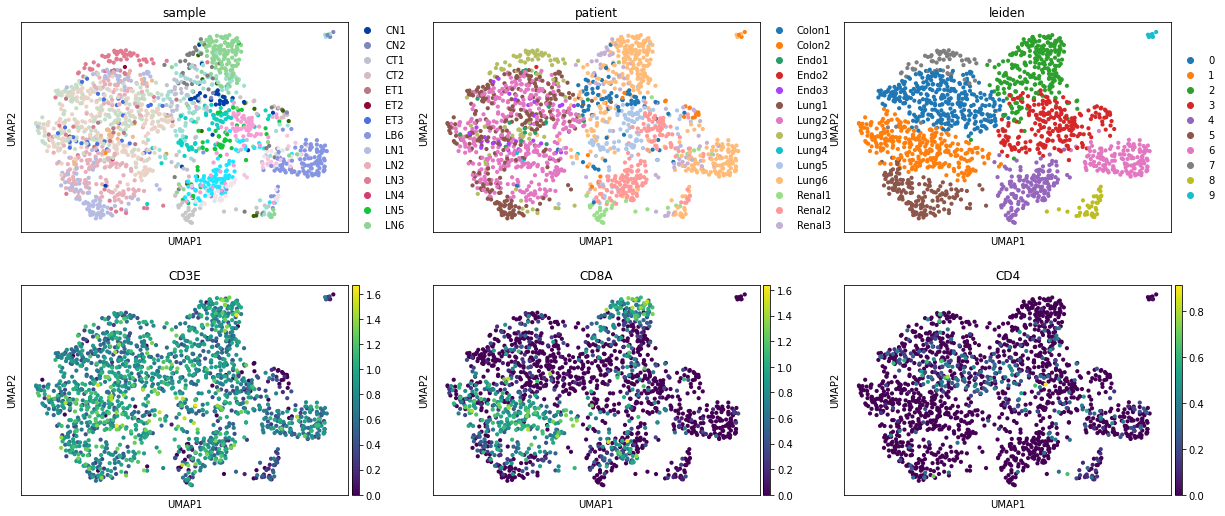

In [10]:
sc.pl.umap(adata, color=["sample", "patient", "leiden", "CD3E", "CD8A", "CD4"], ncols=3)

## TCR QC

It is thought that a single cell can have up to two alpha and two beta chains -- one from each Allele.
Let's check how many TCR chains have been detected

In [11]:
st.tl.chain_pairing(adata)

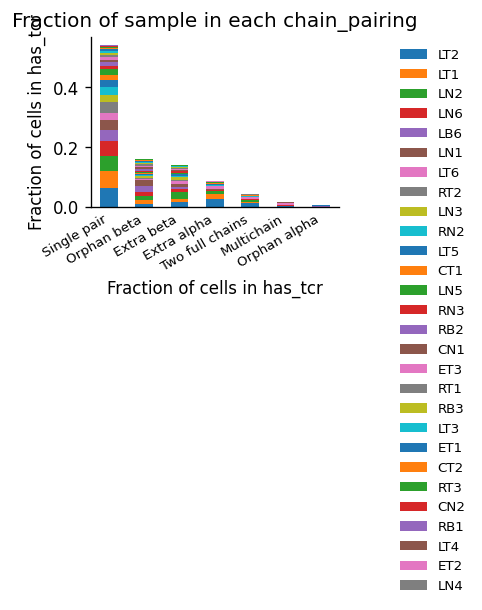

In [12]:
st.pl.group_abundance(
    adata, groupby="chain_pairing", target_col="sample", fraction="has_tcr",
)

The `multi_chain` key stores which cells have more than 2 TRA or 2 TRB chains. They are likely doublets and we will exclude them from the downstream analysis

... storing 'chain_pairing' as categorical


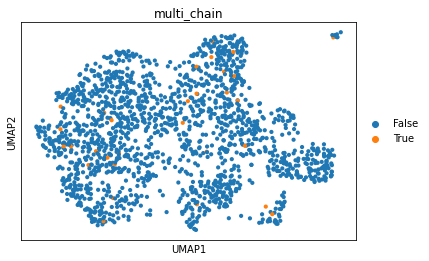

In [13]:
sc.pl.umap(adata, color="multi_chain")

In [14]:
adata = adata[adata.obs["multi_chain"] != "True", :].copy()

## Define clonotypes

Next, we need to define clonotypes

<div class="alert alert-warning">

**Warning:** Clonotype definition will soon change to a graph-based approach

</div>

In [15]:
st.tl.define_clonotypes(adata)

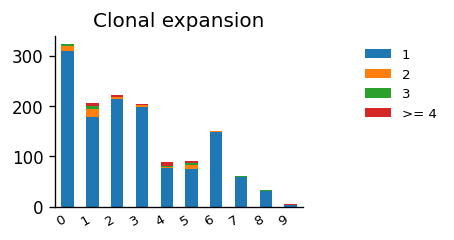

In [16]:
st.pl.clonal_expansion(adata, groupby="leiden", clip_at=4, fraction=False)

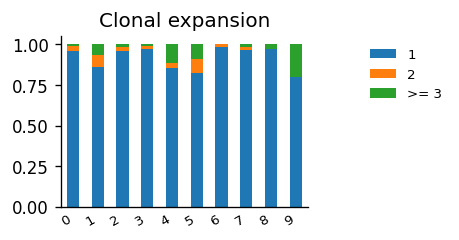

In [17]:
st.pl.clonal_expansion(adata, "leiden")

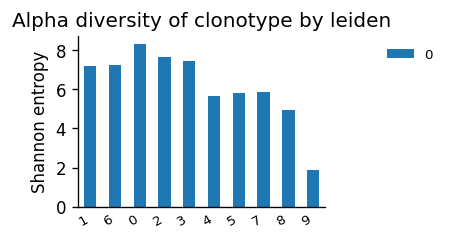

In [18]:
st.pl.alpha_diversity(adata, groupby="leiden")

### Clonotype abundance

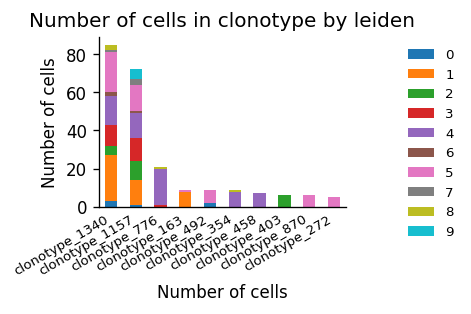

In [19]:
st.pl.group_abundance(
    adata, groupby="clonotype", target_col="leiden", max_cols=10, fraction=False
)

Perhaps an even more straightforward question would be comparing clonotype composition of samples

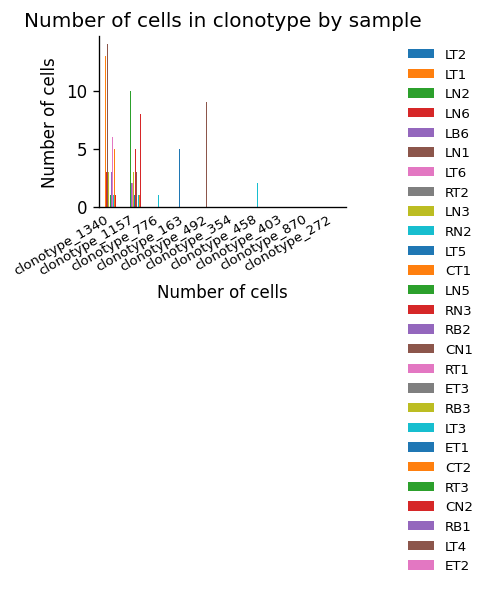

In [20]:
st.pl.group_abundance(
    adata, groupby="clonotype", target_col="sample", max_cols=10, stacked=False
)

If cell types are considered, it is still probably better to normalize to cell numbers in a sample.

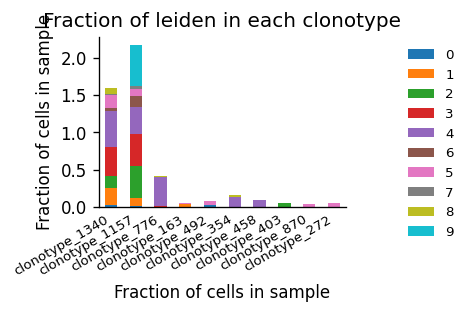

In [21]:
st.pl.group_abundance(
    adata, groupby="clonotype", target_col="leiden", fraction="sample", max_cols=10
)

## Gene usage

Group abundance plots can also give some information on VDJ usage

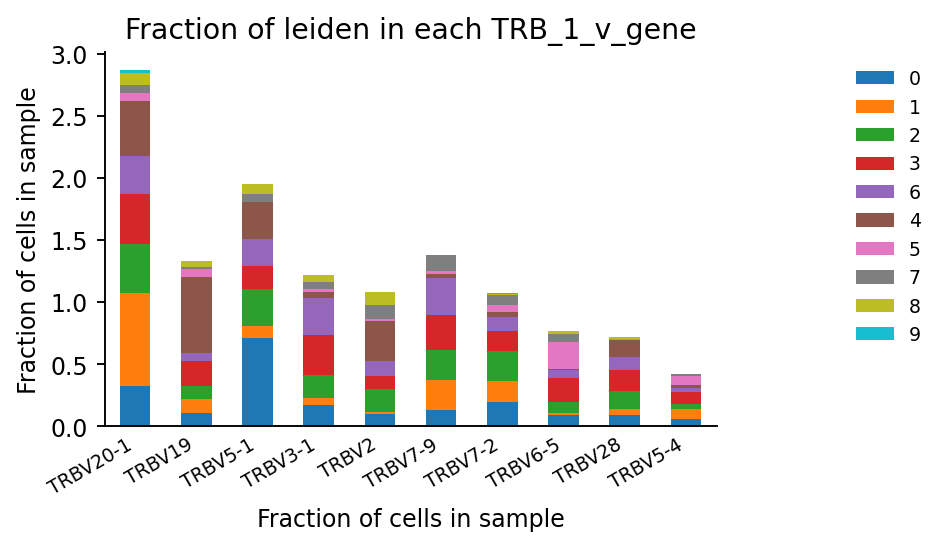

In [22]:
st.pl.group_abundance(
    adata,
    groupby="TRB_1_v_gene",
    target_col="leiden",
    fraction="sample",
    max_cols=10,
    fig_kws={"dpi": 170},
)

In [23]:
vdj_usage = st.tl.group_abundance(
    adata, groupby="leiden", target_col="TRB_1_v_gene", fraction=True
)

In [24]:
vdj_usage = vdj_usage.loc[:, ["TRBV20-1", "TRBV7-2", "TRBV28", "TRBV5-1", "TRBV7-9"]]

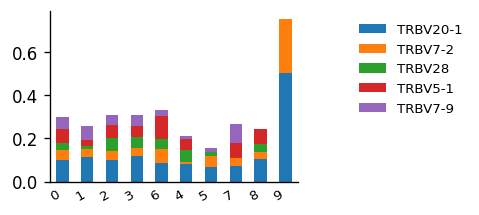

In [25]:
st.pl.base.bar(vdj_usage)

### Spectratype plots

/home/travis/virtualenv/python3.8.0/lib/python3.8/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


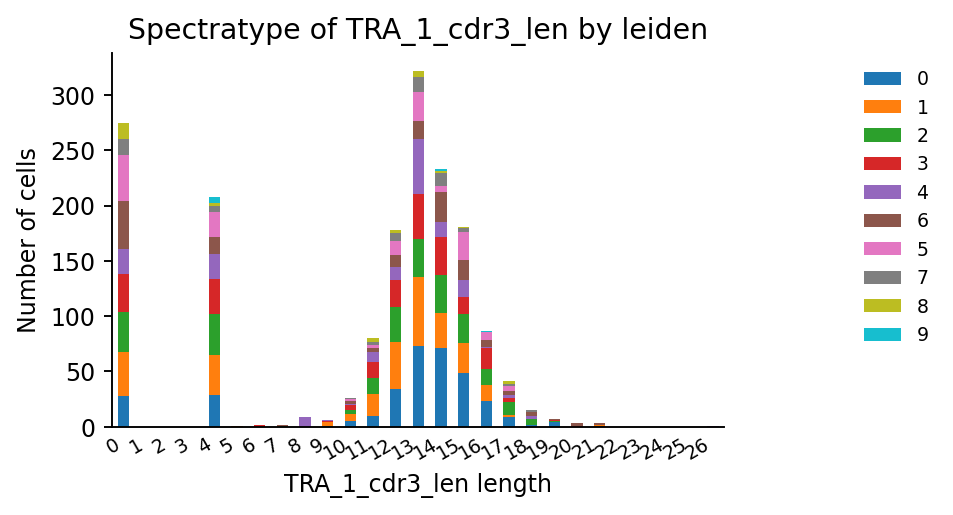

In [26]:
st.pl.spectratype(adata, target_col="leiden",     fig_kws={"dpi": 170},)

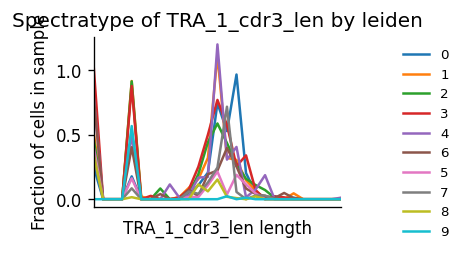

In [27]:
st.pl.spectratype(adata, target_col="leiden", fraction="sample", viztype="line")

/home/travis/virtualenv/python3.8.0/lib/python3.8/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


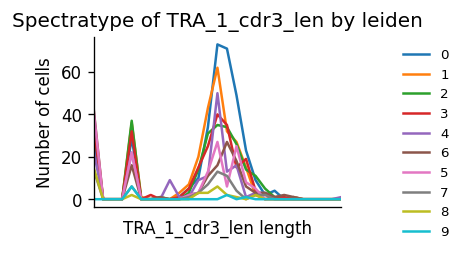

In [28]:
st.pl.spectratype(adata, target_col="leiden", fraction=False, viztype="line")

/home/travis/virtualenv/python3.8.0/lib/python3.8/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


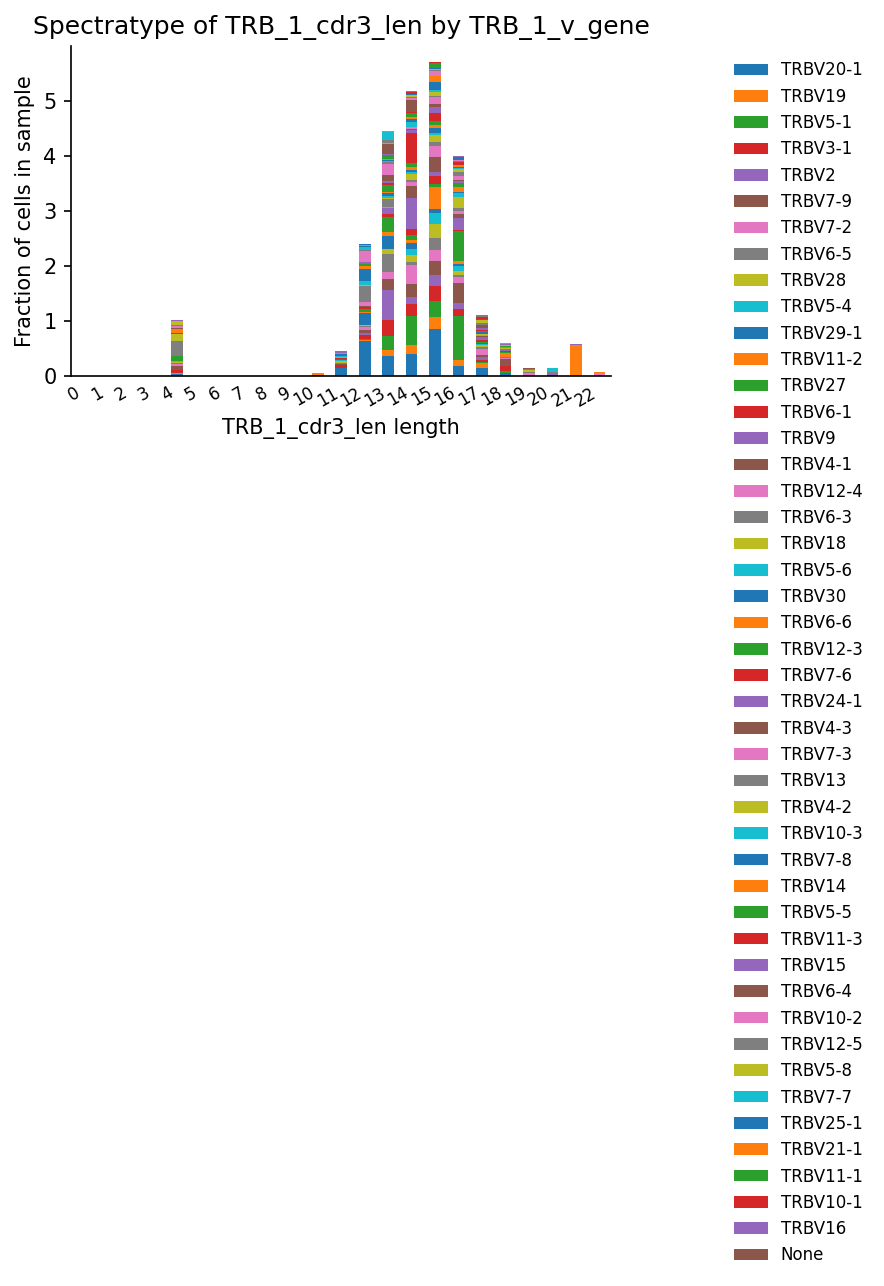

In [29]:
st.pl.spectratype(
    adata, groupby="TRB_1_cdr3_len", target_col="TRB_1_v_gene", fraction="sample", fig_kws={'dpi': 150}
)